In [1]:
from feat import Feat
from pmlb import fetch_data
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
import numpy as np
dataset='690_visualizing_galaxy'
X, y = fetch_data(dataset,return_X_y=True)
X_t,X_v, y_t, y_v = train_test_split(X,y,train_size=0.75,test_size=0.25,random_state=42)

# fix the random state
random_state=11314

fest = Feat(pop_size=500,                                                                        
            gens=100,                  # maximum of 200 generations                            
            max_time=60,              # max time of 60 seconds                                                         
            ml = "LinearRidgeRegression",   # use ridge regression (the default)                                                     
            sel='lexicase',                 # use epsilon lexicase selection (the default)                                                     
            surv='nsga2',                   # use nsga-2 survival (the defaut)                                                    
            max_depth=6,                    # constrain features to depth of 6                                                     
            max_dim=min([X.shape[1]*2,50]), # constrain representation dimensionality to 2x the feature space or 50                                                     
            random_state=random_state,                                                            
            hillclimb=True,                 # use stochastic hillclimbing to optimize weights for 10 iterations                                                  
            iters=10,                                                                            
            n_threads=1,                   # restricts to single thread                                                      
            verbosity=2,                   # verbose output                                                      
            tune_final=False
           ) 

print('FEAT version:', fest.__version__)
# train the model
fest.fit(X_t,y_t)

# get the test score
test_score = {}
test_score['feat'] = mse(y_v,fest.predict(X_v))

# store the archive
archive = fest.get_archive(justfront=True)


FEAT version: 0.4.post37


In [2]:
print('complexity','fitness','validation fitness',
     'eqn')
order = np.argsort([a['complexity'] for a in archive])
complexity = []
fit_train = []
fit_test = []
eqn = []

for o in order:
    model = archive[o]
    if model['pareto_rank'] == 1:
        print(model['complexity'],
              model['fitness'],
              model['fitness_v'],
              model['eqn'],
             )

        complexity.append(model['complexity'])
        fit_train.append(model['fitness'])
        fit_test.append(model['fitness_v'])
        eqn.append(model['eqn'])

complexity fitness validation fitness eqn
1.0 1879.22 1567.89 [x_1]
2.0 933.994 975.519 [x_1][x_3]
3.0 898.233 992.063 [x_0][x_1][x_3]
4.0 864.305 983.88 [x_3][x_1][x_0][x_2]
6.0 677.366 845.516 [x_0][x_1][relu(x_1)]
7.0 499.129 614.08 [tanh(x_1)][x_0]
8.0 442.393 451.051 [tanh(x_1)][x_0][x_3]
9.0 393.422 422.56 [x_0][tanh(x_1)][x_3][x_2]
10.0 386.646 422.836 [sin(x_1)][x_1][x_0][x_2][x_3]
12.0 371.893 368.454 [tanh(x_1)][x_3][x_2][(x_0<0.299924)]
13.0 368.779 334.236 [tanh(x_1)][x_3][tanh(x_0)]
14.0 365.638 466.489 [tanh(x_1)][x_3][x_1][tanh(x_0)]
15.0 356.376 661.079 [x_3][x_0][x_2][x_0][sin(x_1)][x_1][(x_0<0.269587)]
16.0 319.439 397.644 [x_2][sin(x_1)][x_1][x_2][x_3][tanh(x_0)]
17.0 319.397 322.394 [x_3][tanh(x_1)][x_2][x_3][tanh(x_0)][x_3][x_3]
18.0 313.185 335.349 [(tanh(x_0)-x_3)][sin(x_1)][x_1][x_3][x_2][x_3]
19.0 302.686 372.678 [tanh(x_1)][x_2][x_3][tanh(x_0)][x_3][(x_1<-0.687764)]
20.0 299.106 334.919 [x_0][tanh(x_1)][x_2][x_3][tanh(x_0)][x_3][(x_1<-0.731222)]
22.0 291.433 3

In [3]:
from feat import Feat
from pmlb import fetch_data
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import RandomForestRegressor

X, y = fetch_data(dataset,return_X_y=True)
X_t,X_v, y_t, y_v = train_test_split(X,y,train_size=0.75,test_size=0.25,random_state=42)

rf = RandomForestRegressor(random_state=random_state)

rf.fit(X_t,y_t)

# test_score={}

test_score['rf'] = mse(y_v,rf.predict(X_v))


In [4]:
from feat import Feat
from pmlb import fetch_data
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import ElasticNet

X, y = fetch_data(dataset,return_X_y=True)
X_t,X_v, y_t, y_v = train_test_split(X,y,train_size=0.75,test_size=0.25,random_state=random_state)

linest = ElasticNet()

linest.fit(X_t,y_t)

# test_score={}

test_score['elasticnet'] = mse(y_v,linest.predict(X_v))


In [5]:
test_score

{'feat': 246.34226885861085,
 'rf': 337.0935259259262,
 'elasticnet': 955.3797183982998}

/home/bill/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


best: 52.0
middle: 18.0
small: 2.0
complexity [1.0, 2.0, 3.0, 4.0, 6.0, 7.0, 8.0, 9.0, 10.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 22.0, 23.0, 29.0, 30.0, 31.0, 32.0, 33.0, 36.0, 37.0, 39.0, 40.0, 41.0, 43.0, 44.0, 47.0, 49.0, 52.0, 60.0, 86.0, 88.0, 179.0, 187.0, 198.0, 220.0, 284.0, 290.0, 375.0]


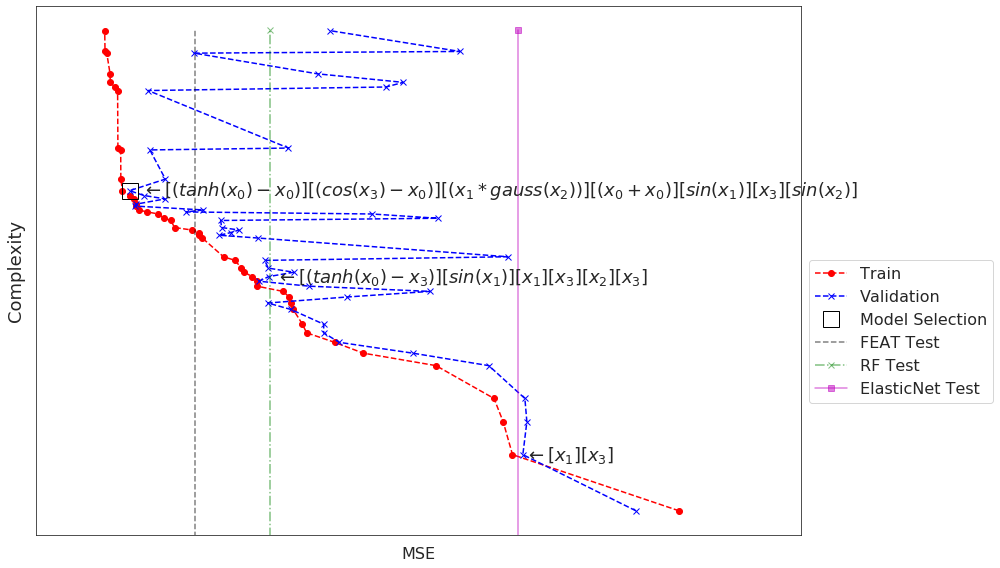

In [6]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import math

matplotlib.rcParams['figure.figsize'] = (10, 6)
%matplotlib inline 
sns.set_style('white')
h = plt.figure(figsize=(14,8))

# plot archive points 
plt.plot(fit_train,complexity,'--ro',label='Train',markersize=6)
plt.plot(fit_test,complexity,'--bx',label='Validation')
# some models to point out
best = np.argmin(np.array(fit_test))
middle = np.argmin(np.abs(np.array(fit_test[:best])-test_score['rf']))
small = np.argmin(np.abs(np.array(fit_test[:middle])-test_score['elasticnet']))

print('best:',complexity[best])
print('middle:',complexity[middle])
print('small:',complexity[small])
plt.plot(fit_test[best],complexity[best],'sk',markersize=16,markerfacecolor='none',label='Model Selection')

# test score lines
y1 = -1
y2 = np.max(complexity)+1
plt.plot((test_score['feat'],test_score['feat']),(y1,y2),'--k',label='FEAT Test',alpha=0.5)
plt.plot((test_score['rf'],test_score['rf']),(y1,y2),'-.xg',label='RF Test',alpha=0.5)
plt.plot((test_score['elasticnet'],test_score['elasticnet']),(y1,y2),'-sm',label='ElasticNet Test',alpha=0.5)

print('complexity',complexity)
# eqn[best] = '0)]$\n$'.join(eqn[best].split('0)]'))
xoff = 10
for e,t,c in zip(eqn,fit_test,complexity):
#     if c in [1,4,12,31,43,53]:
    if c in [complexity[best],complexity[middle],complexity[small]]:
        t = t+xoff
        tax = plt.text(t,c,'$\leftarrow'+e+'$',size=18,horizontalalignment='left',
                      verticalalignment='center')
#         tax.set_bbox(dict(facecolor='white', alpha=0.75, edgecolor='none'))

l = plt.legend(prop={'size': 16},loc=[1.01,0.25])
plt.xlabel('MSE',size=16)
plt.xlim(np.min(fit_train)*.75,np.max(fit_test)*2)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

# plt.ylim(y1,y2)
plt.gca().set_yticklabels('')
plt.gca().set_xticklabels('')

plt.ylabel('Complexity',size=18)
h.tight_layout()
h.savefig('archive_example.svg')

plt.show()

In [7]:
model = fest.get_model()
print(model)
# for m in model.split('\n')[1:-1]:
#     phi = m.split('\t')[0].replace('tanh','\\tanh').replace('*',' \\cdot ')
#     beta = m.split('\t')[1]
#     print('$'+phi+'$','&',round(float(beta),1),end=' \\\\\n')

Feature		Weight
offset		1592.81
tanh(tanh(x_1))		-110.999428
logit((x_3-x_1))		92.090294
(x_1*gauss(x_2))		-85.290421
(x_0-x_1)		-29.049520
sin(exp(x_1))		23.415312
(x_0*log(x_0))		-14.195452
(cos(x_1)*log(x_0))		4.585493
x_2		4.038371

